In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
# %tensorflow_version 2.x
import tensorflow
# tensorflow.__version__
import random

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
import tensorflow as tf
from keras import callbacks

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
# Initialize the random number generator
random.seed(1)

<IPython.core.display.Javascript object>

In [4]:
from tensorflow.keras.models import Sequential      # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D          # This layer creates a convolution kernel that is convolved 
                                                    # with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D    # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten         # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout  # Dropout: Applies Dropout to the input.
                                                    # Dense: Just your regular densely-connected NN layer.
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

<IPython.core.display.Javascript object>

In [5]:
import numpy as np                               # Import numpy
from skimage import data, io                     # Import skimage library (data - Test images and example data.
                                                 #                          io - Reading, saving, and displaying images.) 
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)

import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

<IPython.core.display.Javascript object>

In [6]:
# # From  https://www.tensorflow.org/tutorials/load_data/images

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

<IPython.core.display.Javascript object>

In [7]:
ds_url = "https://olympus.mygreatlearning.com/courses/58531/files/4929964/download?verifier=c1Lp5f9eeJnuid9kIt5ZNXzhuTnPYJHJSAOgKr0B&wrap=1"
data_zip = tf.keras.utils.get_file(
    origin=ds_url, fname='shapes.tar.gz', extract=True, 
)
print(data_zip)
data_dir = pathlib.Path(data_zip.replace(".tar.gz", ""))
print(data_dir)
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)


/Users/sgirolkar/.keras/datasets/shapes.tar.gz
/Users/sgirolkar/.keras/datasets/shapes
300


<IPython.core.display.Javascript object>

In [8]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

<IPython.core.display.Javascript object>

In [9]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

<IPython.core.display.Javascript object>

In [10]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

<IPython.core.display.Javascript object>

In [11]:
batch_size = 32
img_height = 28
img_width = 28

<IPython.core.display.Javascript object>

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/Training",
    # validation_split=0.0,
    # subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)   

Found 240 files belonging to 3 classes.


<IPython.core.display.Javascript object>

In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  f"{data_dir}/Testing",
  # validation_split=0.0,
  # subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical"
)

Found 60 files belonging to 3 classes.


<IPython.core.display.Javascript object>

In [14]:
class_names = train_ds.class_names
print(class_names)

['circles', 'squares', 'triangles']


<IPython.core.display.Javascript object>

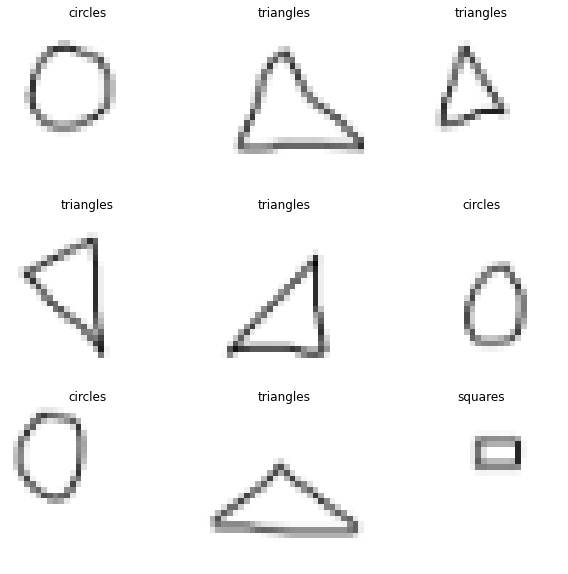

<IPython.core.display.Javascript object>

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        lb = list(labels[i])
        cls_lb = class_names[lb.index(1)]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))    
        plt.title(cls_lb)
        plt.axis("off")

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

<IPython.core.display.Javascript object>

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.19215688 1.0


<IPython.core.display.Javascript object>

In [18]:
# AUTOTUNE = tf.data.AUTOTUNE

# normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
# normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<IPython.core.display.Javascript object>

In [19]:
# Initialising the CNN classifier
classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))

# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))

# The final output layer with 3 neurons to predict the categorical classifcation
classifier.add(Dense(units = 3, activation = 'softmax'))

<IPython.core.display.Javascript object>

In [20]:
''' Compile model (using the efficient Adam gradient descent optimization algorithm
    with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.)'''
classifier.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    # loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),    
    # loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

<IPython.core.display.Javascript object>

In [21]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0

<IPython.core.display.Javascript object>

In [22]:
# adding earlystopping callback
es= callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, 
    mode='min', 
    restore_best_weights= True
)

checkpoint_filepath = '/tmp/checkpoint'

mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# #add class weights
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(training_set), y=test_set)
# class_weights = dict(enumerate(class_weights))


<IPython.core.display.Javascript object>

In [23]:
# There are 240 training images and 60 test images in total
history = classifier.fit(
    normalized_ds,
    # steps_per_epoch = int(240/32),
    epochs = 100,
    validation_data = normalized_val_ds,
    # validation_steps = int(60/32),
    # validation_split=0.2, 
    batch_size=batch_size, 
    callbacks=[es, mc], 
    verbose=1,
    # class_weight=class_weights
)

Epoch 1/100
8/8 [==============================] - 2s 95ms/step - loss: 1.1124 - accuracy: 0.3458 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/100
8/8 [==============================] - 0s 47ms/step - loss: 1.0964 - accuracy: 0.3708 - val_loss: 1.0956 - val_accuracy: 0.4667
Epoch 3/100
8/8 [==============================] - 0s 41ms/step - loss: 1.1040 - accuracy: 0.3083 - val_loss: 1.0954 - val_accuracy: 0.3333
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 1.1087 - accuracy: 0.2875 - val_loss: 1.0941 - val_accuracy: 0.3333
Epoch 5/100
8/8 [==============================] - 0s 46ms/step - loss: 1.0982 - accuracy: 0.3625 - val_loss: 1.0937 - val_accuracy: 0.5833
Epoch 6/100
8/8 [==============================] - 0s 40ms/step - loss: 1.0994 - accuracy: 0.3458 - val_loss: 1.0896 - val_accuracy: 0.3333
Epoch 7/100
8/8 [==============================] - 0s 42ms/step - loss: 1.0925 - accuracy: 0.3542 - val_loss: 1.0837 - val_accuracy: 0.3500
Epoch 8/100
8/8 [===

<IPython.core.display.Javascript object>

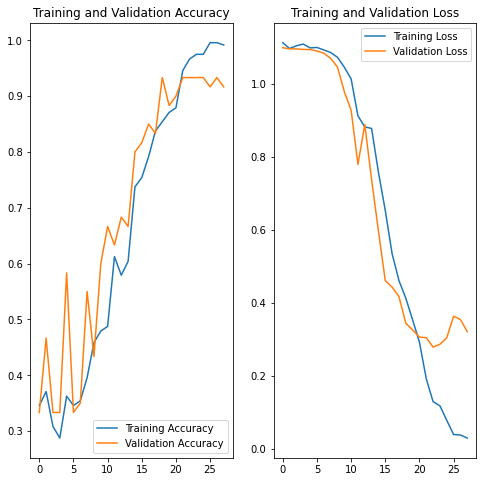

<IPython.core.display.Javascript object>

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<AxesSubplot:>

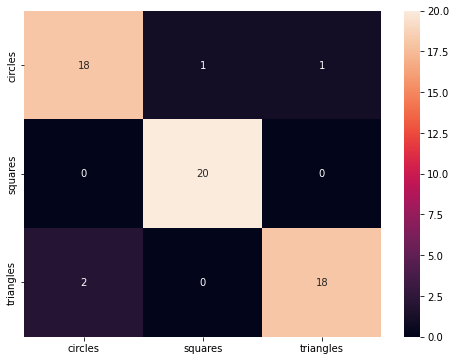

<IPython.core.display.Javascript object>

In [25]:
predictions = np.array([])
labels =  np.array([])
for x, y in normalized_val_ds:
    predictions = np.concatenate([predictions, np.argmax(classifier.predict(x), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

cf_matrix_n2 = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n2, xticklabels=class_names, yticklabels=class_names, annot=True)

<AxesSubplot:>

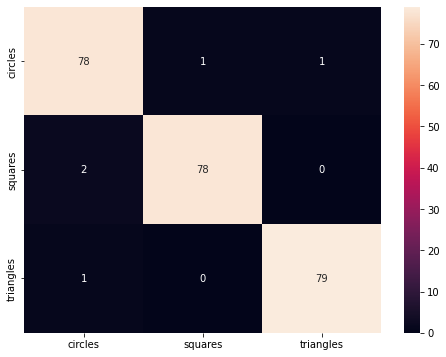

<IPython.core.display.Javascript object>

In [26]:
predictions = np.array([])
labels =  np.array([])
for x, y in normalized_ds:
    predictions = np.concatenate([predictions, np.argmax(classifier.predict(x), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

cf_matrix_n1 = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n1, xticklabels=class_names, yticklabels=class_names, annot=True)